In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
anndata2ri                  1.0.6
appnope                     0.1.2
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.2
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.7
cloudpickle                 2.0.0
cycler                      0.10.0
cython_runtime              NA
cytoolz  

In [6]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")


In [20]:
%%R
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [47]:
data_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069.matrix.txt"
matrix = pd.read_csv(data_file, delimiter="\t")
#drop 1 column with nan
matrix = matrix.dropna(axis="columns")
#convert to numpy array
sparse_matrix = matrix.iloc[:, 2:]
sparse_matrix = sparse_matrix.to_numpy()
#save sparse_matrix as csv
pd.DataFrame(sparse_matrix).to_csv("/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_matrix.csv", header=None, index=None)

In [57]:
data_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069.matrix.txt"
matrix = pd.read_csv(data_file, delimiter="\t")
#drop 1 column with nan
matrix = matrix.dropna(axis="columns")

genes = matrix.iloc[:, 0:2]
pd.DataFrame(genes).to_csv("/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_genes.csv", header=None, index=None)

In [58]:
data_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069.matrix.txt"
matrix = pd.read_csv(data_file, delimiter="\t")
#drop 1 column with nan
matrix = matrix.dropna(axis="columns")

barcodes = matrix.iloc[:, 2:].columns.values
barcodes.transpose()
pd.DataFrame(barcodes).to_csv("/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_barcodes.csv", header=None, index=None)

In [76]:
matrix = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_matrix.csv"
barcode_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_barcodes.csv"
gene_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_genes.csv"

#Load data
#this is in the format genes x cells
#scanpy expects cells x genes and so must transpose
adata = sc.read(matrix, cache=True)
adata = adata.transpose()

barcodes = pd.read_csv(barcode_file, header=None)
genes = pd.read_csv(gene_file, header=None)

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)

genes.set_index('gene_symbol', inplace=True)

adata.var = genes
print(adata.var) #this looks the same as the tutorial



... reading from cache file cache/Users-esthomas-Andor_Rotation-github_repo-cross-modal-autoencoders-data_folder-my_data-GSM4567140_PJ069_matrix.h5ad
                          gene_id
gene_symbol                      
IL36A           ENSG00000136694.8
TRAV1-1         ENSG00000255569.1
LARP1BP1        ENSG00000231442.3
ATP13A5-AS1     ENSG00000236508.1
NKAIN2         ENSG00000188580.13
...                           ...
BX682235.1      ENSG00000234404.2
RNA5SP508       ENSG00000223259.1
HSPA8P1         ENSG00000234176.1
PPP2R2DP1       ENSG00000231668.2
RP11-718B12.1   ENSG00000255063.1

[60725 rows x 1 columns]


In [82]:
print(adata.var_names)
adata.var_names_make_unique()
print(adata.var_names)

Index(['IL36A', 'TRAV1-1', 'LARP1BP1', 'ATP13A5-AS1', 'NKAIN2', 'Metazoa_SRP',
       'HMGB1P44', 'OR5W1P', 'RFPL2', 'RNU6-938P',
       ...
       'SOWAHA', 'SSU72P8', 'AC055811.1', 'C17orf104', 'LINC00917',
       'BX682235.1', 'RNA5SP508', 'HSPA8P1', 'PPP2R2DP1', 'RP11-718B12.1'],
      dtype='object', name='gene_symbol', length=60725)
Index(['IL36A', 'TRAV1-1', 'LARP1BP1', 'ATP13A5-AS1', 'NKAIN2', 'Metazoa_SRP',
       'HMGB1P44', 'OR5W1P', 'RFPL2', 'RNU6-938P',
       ...
       'SOWAHA', 'SSU72P8', 'AC055811.1', 'C17orf104', 'LINC00917',
       'BX682235.1', 'RNA5SP508', 'HSPA8P1', 'PPP2R2DP1', 'RP11-718B12.1'],
      dtype='object', name='gene_symbol', length=60725)


In [83]:
#check for duplicate var names
from collections import Counter
[k for k,v in Counter(adata.var_names).items() if v>1]

[]

In [94]:
#counts per transcript
print(len(adata.X.sum(1)))
print(adata.X.sum(1))

print(len((adata.X > 0).sum(1)))
print((adata.X > 0).sum(1))



1954
[27100. 15237. 13244. ...  1005.  1002.  1001.]
1954
[7450 5489 5000 ...  753  730  699]


In [84]:
# Quality control - calculate QC covariates
# number of molecule counts (UMIs)
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

# MT- prefix for mitochondria
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

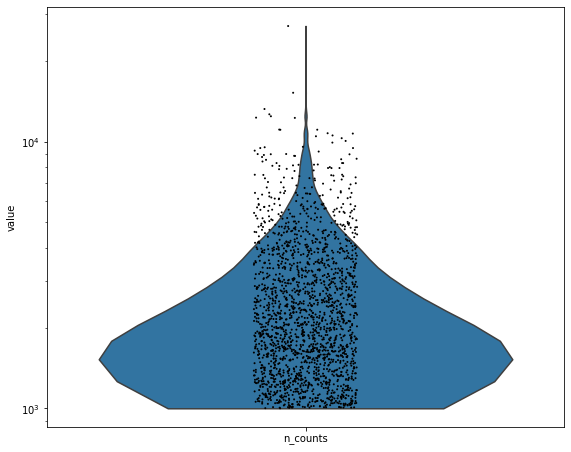

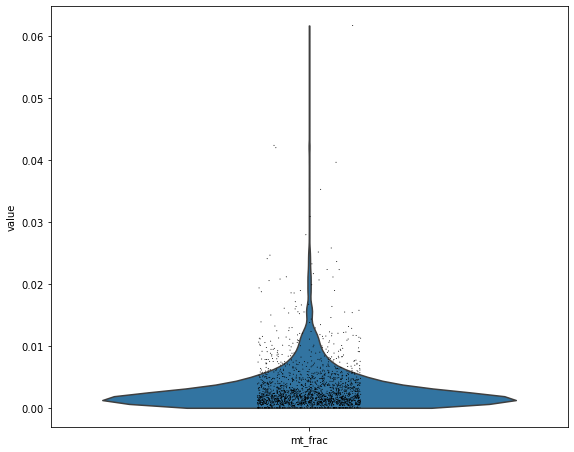

In [85]:
#Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')

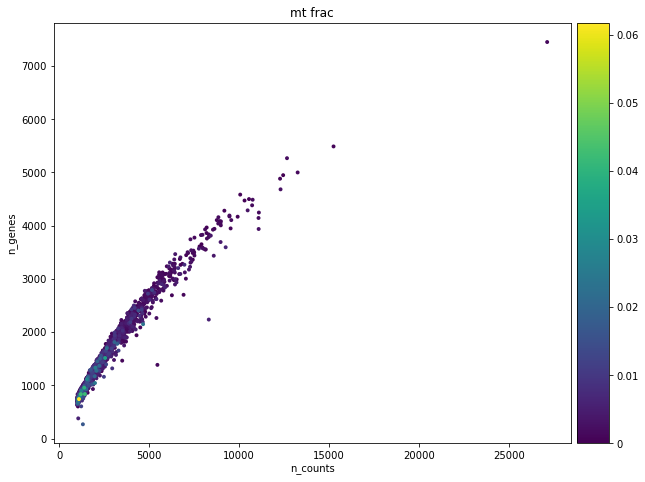

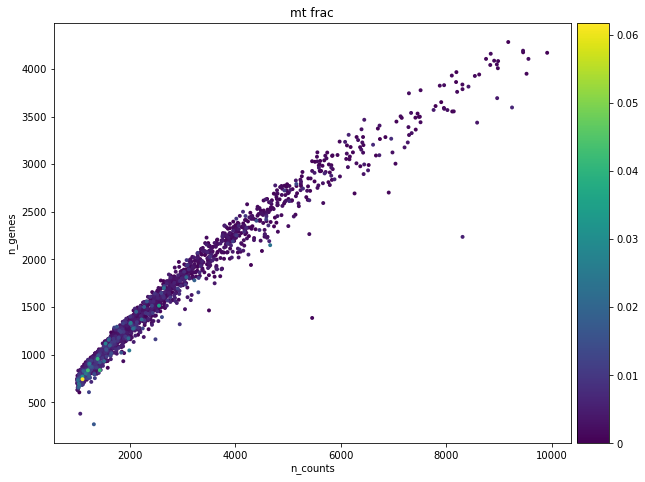

In [95]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')